# **COSE474-02 Deep Learning Final Project : Exploring Reinforcement Learning Fine-Tuning Techniques Optimized for CLIP Models**

Student ID : 2020220052  
Student Name : 정인아  
Department : 디자인조형학부/컴퓨터학과  

### **1. 환경 설정**

In [1]:
# Kaggle API 설정
!mkdir -p ~/.kaggle
!echo '{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# 데이터셋 불러오기
!kaggle datasets download -d eeshawn/flickr30k
!unzip flickr30k.zip -d ./flickr30k

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./flickr30k/flickr30k_images/5354811242.jpg  
  inflating: ./flickr30k/flickr30k_images/5354904685.jpg  
  inflating: ./flickr30k/flickr30k_images/5354911151.jpg  
  inflating: ./flickr30k/flickr30k_images/535529555.jpg  
  inflating: ./flickr30k/flickr30k_images/5356236664.jpg  
  inflating: ./flickr30k/flickr30k_images/5356318668.jpg  
  inflating: ./flickr30k/flickr30k_images/535830521.jpg  
  inflating: ./flickr30k/flickr30k_images/5359437945.jpg  
  inflating: ./flickr30k/flickr30k_images/5361355399.jpg  
  inflating: ./flickr30k/flickr30k_images/53614287.jpg  
  inflating: ./flickr30k/flickr30k_images/536147209.jpg  
  inflating: ./flickr30k/flickr30k_images/5361551308.jpg  
  inflating: ./flickr30k/flickr30k_images/536156200.jpg  
  inflating: ./flickr30k/flickr30k_images/5362687336.jpg  
  inflating: ./flickr30k/flickr30k_images/5363528971.jpg  
  inflating: ./flickr30k/flickr30k_images/5363903246.jpg  
  inflating: ./flickr30k/f

In [2]:
# 라이브러리 불러오기
import os
import csv
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 파일 경로
data_dir = './flickr30k'
captions_file = os.path.join(data_dir, 'captions.txt')

# 데이터 초기화
captions_dict = {}
image_list = set()

# 데이터 구조화
with open(captions_file, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filename = row['image_name']
        caption = row['comment']

        if filename not in captions_dict:
            captions_dict[filename] = []
        captions_dict[filename].append(caption)
        image_list.add(filename)

# 이미지 리스트 생성
image_list = list(image_list)

# train/test 데이터셋 나누기
train_images, test_images = train_test_split(image_list, test_size=0.02, random_state=42)

# 이미지-캡션 매칭
train_captions = {img: captions_dict[img] for img in train_images}
test_captions = {img: captions_dict[img] for img in test_images}

# test용 이미지 리스트 저장
test_images = list(test_captions.keys())

In [6]:
# CLIP, Processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

### **2. CLIP 모델**

In [7]:
def calculate_similarity(image_path, captions):
    # 전처리
    image = Image.open(image_path)
    inputs = processor(
        text=captions,
        images=image,
        return_tensors="pt",
        padding=True
    )

    # 모델 예측 (유사도 점수를 확률로 계산)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    # 엔트로피 계산
    entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1).item()

    return probs, entropy

In [8]:
# 첫 번째 이미지 테스트
sample_image = './flickr30k/flickr30k_images/' + test_images[0]
sample_captions = test_captions[test_images[0]]

# 유사도 계산
probs = calculate_similarity(sample_image, sample_captions)

# 결과 출력
print(f"Test image: {test_images[0]}")
for caption, prob in zip(sample_captions, probs[0][0]):
    print(f"Caption: {caption} | Probability: {prob:.4f}")

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Test image: 4645120146.jpg
Caption:  A man wearing long sleeves and a baseball cap walks along the sidewalk between a parked car and a store that advertises " Real Meat Real Butcher " . | Probability: 0.9998
Caption: A man walking on the street with a baseball cap and black long-sleeve shirt . | Probability: 0.0000
Caption: A man in a black and white baseball cap looking into a silver pontiac . | Probability: 0.0001
Caption: A man in a baseball cap walking between a car and a market . | Probability: 0.0000
Caption: A man in a black shirt wearing a white and black hat . | Probability: 0.0000


In [9]:
# CLIP 모델 평가
total_entropies_clip = []
diversity_indices_clip = []
effective_caption_numbers_clip = []

for i, img in enumerate(test_images):
    image_path = './flickr30k/flickr30k_images/' + img
    captions = test_captions[img]
    probs, entropy = calculate_similarity(image_path, captions)

    # 엔트로피 계산
    total_entropies_clip.append(entropy)

    # Diversity Index 계산
    num_captions = len(captions)
    unique_prob_pairs = set()
    for j in range(num_captions):
        for l in range(j + 1, num_captions):
            # 유사도 계산 (1D 텐서를 비교)
            similarity = torch.nn.functional.cosine_similarity(
                probs[0, j].unsqueeze(0), probs[0, l].unsqueeze(0), dim=0  # dim=0으로 수정
            )
            unique_prob_pairs.add(similarity.item())
    diversity_index = 1 - (len(unique_prob_pairs) / num_captions if num_captions > 0 else 0)
    diversity_indices_clip.append(diversity_index)

    # Effective Number of Captions 계산
    effective_captions = 1 / torch.sum(probs[0]**2).item()
    effective_caption_numbers_clip.append(effective_captions)

# 전체 엔트로피, Diversity Index, Effective Number of Captions 계산
overall_entropy = sum(total_entropies_clip) / len(total_entropies_clip)
overall_diversity_index = sum(diversity_indices_clip) / len(diversity_indices_clip)
overall_effective_caption_number = sum(effective_caption_numbers_clip) / len(effective_caption_numbers_clip)

# 결과 출력
print(f"\nTotal entropy (CLIP): {overall_entropy:.4f}")
print(f"Average Diversity Index (CLIP): {overall_diversity_index:.4f}")
print(f"Average Effective Number of Captions (CLIP): {overall_effective_caption_number:.4f}")



Total entropy (CLIP): 0.8323
Average Diversity Index (CLIP): 0.7997
Average Effective Number of Captions (CLIP): 2.0877


### **3. CLIP 모델 Finetuning**

In [10]:
# 가장 최근 파라미터 로드
output_dir_param = "/content/drive/MyDrive/DL/parameters/clip_finetune/clip_finetuning_4"
model = CLIPModel.from_pretrained(output_dir_param)
processor = CLIPProcessor.from_pretrained(output_dir_param)

In [11]:
# 첫 번째 이미지 테스트
sample_image = './flickr30k/flickr30k_images/' + test_images[0]
sample_captions = test_captions[test_images[0]]

# 유사도 계산
probs = calculate_similarity(sample_image, sample_captions)

# 결과 출력
print(f"Test image: {test_images[0]}")
for caption, prob in zip(sample_captions, probs[0][0]):
    print(f"Caption: {caption} | Probability: {prob:.4f}")

Test image: 4645120146.jpg
Caption:  A man wearing long sleeves and a baseball cap walks along the sidewalk between a parked car and a store that advertises " Real Meat Real Butcher " . | Probability: 0.0441
Caption: A man walking on the street with a baseball cap and black long-sleeve shirt . | Probability: 0.0815
Caption: A man in a black and white baseball cap looking into a silver pontiac . | Probability: 0.6556
Caption: A man in a baseball cap walking between a car and a market . | Probability: 0.1458
Caption: A man in a black shirt wearing a white and black hat . | Probability: 0.0729


In [12]:
# 파인튜닝한 CLIP 모델 평가
total_entropies_clip_finetuning = []
diversity_indices_clip_finetuning = []
effective_caption_numbers_clip_finetuning = []

for i, img in enumerate(test_images):
    image_path = './flickr30k/flickr30k_images/' + img
    captions = test_captions[img]

    # 확률 분포와 엔트로피 계산
    probs, entropy = calculate_similarity(image_path, captions)

    # 엔트로피 추가
    total_entropies_clip_finetuning.append(entropy)

    # Diversity Index 계산
    num_captions = len(captions)
    if num_captions > 1:
        unique_prob_pairs = set()
        for j in range(num_captions):
            for k in range(j + 1, num_captions):
                similarity = torch.nn.functional.cosine_similarity(
                    probs[0, j].unsqueeze(0), probs[0, k].unsqueeze(0), dim=0
                )
                unique_prob_pairs.add(similarity.item())
        diversity_index = 1 - (len(unique_prob_pairs) / num_captions)
    else:
        diversity_index = 0  # 캡션이 하나일 경우 다양성 없음
    diversity_indices_clip_finetuning.append(diversity_index)

    # Effective Number of Captions 계산
    effective_captions = 1 / torch.sum(probs[0]**2).item()
    effective_caption_numbers_clip_finetuning.append(effective_captions)

# 전체 엔트로피, Diversity Index, Effective Number of Captions 계산
overall_entropy = sum(total_entropies_clip_finetuning) / len(total_entropies_clip_finetuning)
overall_diversity_index = sum(diversity_indices_clip_finetuning) / len(diversity_indices_clip_finetuning)
overall_effective_caption_number = sum(effective_caption_numbers_clip_finetuning) / len(effective_caption_numbers_clip_finetuning)

# 결과 출력
print(f"\nTotal entropy (CLIP Finetuning): {overall_entropy:.4f}")
print(f"Average Diversity Index (CLIP Finetuning): {overall_diversity_index:.4f}")
print(f"Average Effective Number of Captions (CLIP Finetuning): {overall_effective_caption_number:.4f}")



Total entropy (CLIP Finetuning): 1.2116
Average Diversity Index (CLIP Finetuning): 0.8000
Average Effective Number of Captions (CLIP Finetuning): 2.9972


### **4. DPO**

In [13]:
# 가장 최근 파라미터 로드
output_dir_param = "/content/drive/MyDrive/DL/parameters/dpo_finetune/clip_finetuning_dpo_4"
model = CLIPModel.from_pretrained(output_dir_param)
processor = CLIPProcessor.from_pretrained(output_dir_param)

In [14]:
# 첫 번째 이미지 테스트
sample_image = './flickr30k/flickr30k_images/' + test_images[0]
sample_captions = test_captions[test_images[0]]

# 유사도 계산
probs = calculate_similarity(sample_image, sample_captions)

# 결과 출력
print(f"Test image: {test_images[0]}")
for caption, prob in zip(sample_captions, probs[0][0]):
    print(f"Caption: {caption} | Probability: {prob:.4f}")

Test image: 4645120146.jpg
Caption:  A man wearing long sleeves and a baseball cap walks along the sidewalk between a parked car and a store that advertises " Real Meat Real Butcher " . | Probability: 0.1926
Caption: A man walking on the street with a baseball cap and black long-sleeve shirt . | Probability: 0.2027
Caption: A man in a black and white baseball cap looking into a silver pontiac . | Probability: 0.1964
Caption: A man in a baseball cap walking between a car and a market . | Probability: 0.2023
Caption: A man in a black shirt wearing a white and black hat . | Probability: 0.2060


In [15]:
# 평가
total_entropies_clip_dpo = []
diversity_indices_clip_dpo = []
effective_caption_numbers_clip_dpo = []

for i, img in enumerate(test_images):
    image_path = './flickr30k/flickr30k_images/' + img
    captions = test_captions[img]
    probs, entropy = calculate_similarity(image_path, captions)

    # 엔트로피 계산
    total_entropies_clip_dpo.append(entropy)

    # Diversity Index 계산
    num_captions = len(captions)
    if num_captions > 1:
        unique_prob_pairs = set()
        for j in range(num_captions):
            for k in range(j + 1, num_captions):
                similarity = torch.nn.functional.cosine_similarity(
                    probs[0, j].unsqueeze(0), probs[0, k].unsqueeze(0), dim=0
                )
                unique_prob_pairs.add(similarity.item())
        diversity_index = 1 - (len(unique_prob_pairs) / num_captions)
    else:
        diversity_index = 0  # 캡션이 하나뿐인 경우 다양성 없음
    diversity_indices_clip_dpo.append(diversity_index)

    # Effective Number of Captions 계산
    effective_captions = 1 / torch.sum(probs[0] ** 2).item()
    effective_caption_numbers_clip_dpo.append(effective_captions)

# 전체 지표 계산
overall_entropy = sum(total_entropies_clip_dpo) / len(total_entropies_clip_dpo)
overall_diversity_index = sum(diversity_indices_clip_dpo) / len(diversity_indices_clip_dpo)
overall_effective_caption_number = sum(effective_caption_numbers_clip_dpo) / len(effective_caption_numbers_clip_dpo)

# 결과 출력
print(f"\nTotal entropy (CLIP+DPO): {overall_entropy:.4f}")
print(f"Average Diversity Index (CLIP+DPO): {overall_diversity_index:.4f}")
print(f"Average Effective Number of Captions (CLIP+DPO): {overall_effective_caption_number:.4f}")



Total entropy (CLIP+DPO): 1.6089
Average Diversity Index (CLIP+DPO): 0.8000
Average Effective Number of Captions (CLIP+DPO): 4.9944


### **5. TPO**

In [16]:
# 가장 최근 파라미터 로드
output_dir_param = "/content/drive/MyDrive/DL/parameters/tpo_finetune/clip_finetuning_tpo_4"
model = CLIPModel.from_pretrained(output_dir_param)
processor = CLIPProcessor.from_pretrained(output_dir_param)

In [17]:
# 첫 번째 이미지 테스트
sample_image = './flickr30k/flickr30k_images/' + test_images[0]
sample_captions = test_captions[test_images[0]]

# 유사도 계산
probs = calculate_similarity(sample_image, sample_captions)

# 결과 출력
print(f"Test image: {test_images[0]}")
for caption, prob in zip(sample_captions, probs[0][0]):
    print(f"Caption: {caption} | Probability: {prob:.4f}")

Test image: 4645120146.jpg
Caption:  A man wearing long sleeves and a baseball cap walks along the sidewalk between a parked car and a store that advertises " Real Meat Real Butcher " . | Probability: 0.2013
Caption: A man walking on the street with a baseball cap and black long-sleeve shirt . | Probability: 0.1996
Caption: A man in a black and white baseball cap looking into a silver pontiac . | Probability: 0.2000
Caption: A man in a baseball cap walking between a car and a market . | Probability: 0.1993
Caption: A man in a black shirt wearing a white and black hat . | Probability: 0.1998


In [18]:
# 평가
total_entropies_clip_tpo = []
diversity_indices_clip_tpo = []
effective_caption_numbers_clip_tpo = []

for i, img in enumerate(test_images):
    image_path = './flickr30k/flickr30k_images/' + img
    captions = test_captions[img]
    probs, entropy = calculate_similarity(image_path, captions)

    # 엔트로피 계산
    total_entropies_clip_tpo.append(entropy)

    # Diversity Index 계산
    num_captions = len(captions)
    if num_captions > 1:
        unique_prob_pairs = set()
        for j in range(num_captions):
            for k in range(j + 1, num_captions):
                similarity = torch.nn.functional.cosine_similarity(
                    probs[0, j].unsqueeze(0), probs[0, k].unsqueeze(0), dim=0
                )
                unique_prob_pairs.add(similarity.item())
        diversity_index = 1 - (len(unique_prob_pairs) / num_captions)
    else:
        diversity_index = 0  # 캡션이 하나뿐인 경우 다양성 없음
    diversity_indices_clip_tpo.append(diversity_index)

    # Effective Number of Captions 계산
    effective_captions = 1 / torch.sum(probs[0] ** 2).item()
    effective_caption_numbers_clip_tpo.append(effective_captions)

# 전체 지표 계산
overall_entropy = sum(total_entropies_clip_tpo) / len(total_entropies_clip_tpo)
overall_diversity_index = sum(diversity_indices_clip_tpo) / len(diversity_indices_clip_tpo)
overall_effective_caption_number = sum(effective_caption_numbers_clip_tpo) / len(effective_caption_numbers_clip_tpo)

# 결과 출력
print(f"\nTotal entropy (CLIP+TPO): {overall_entropy:.4f}")
print(f"Average Diversity Index (CLIP+TPO): {overall_diversity_index:.4f}")
print(f"Average Effective Number of Captions (CLIP+TPO): {overall_effective_caption_number:.4f}")



Total entropy (CLIP+TPO): 1.6094
Average Diversity Index (CLIP+TPO): 0.8000
Average Effective Number of Captions (CLIP+TPO): 4.9999


<ipython-input-31-e6fc1678244a>:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


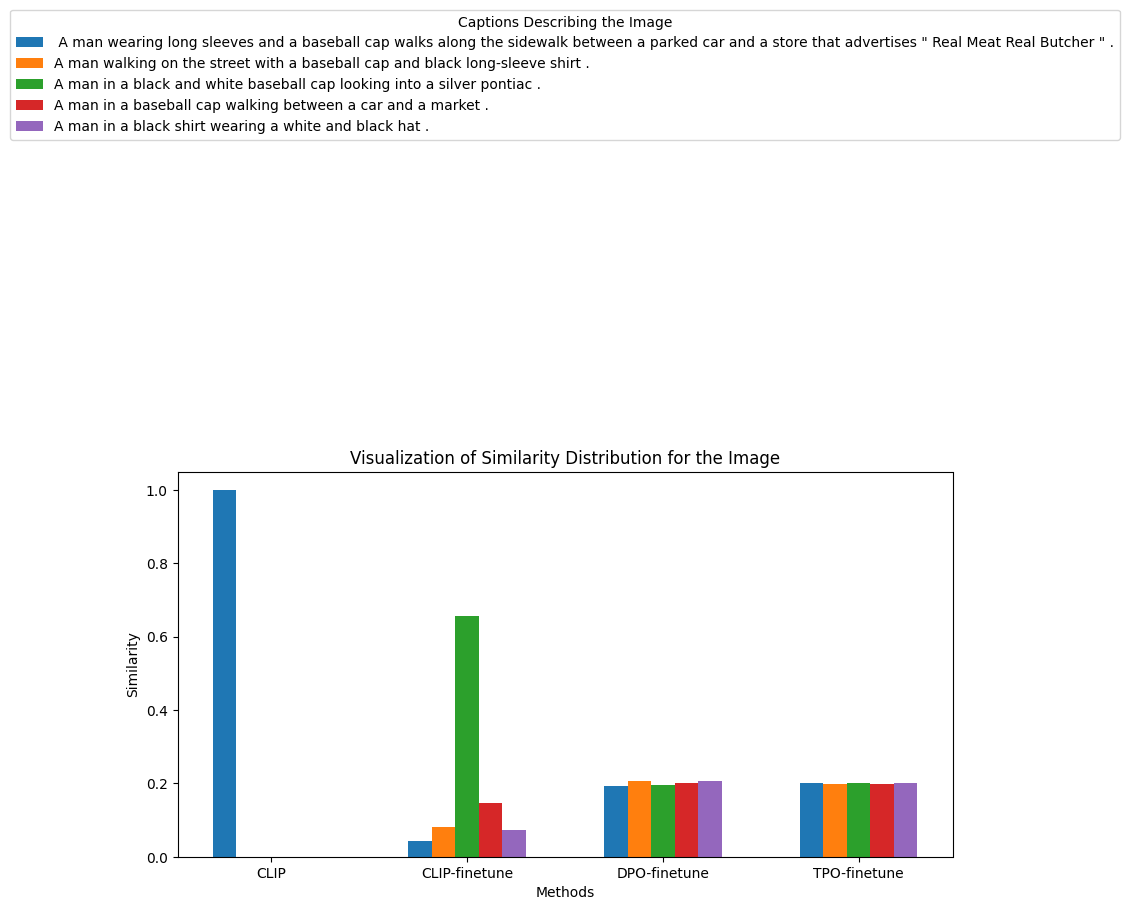

In [31]:
import numpy as np
group_names = sample_captions
categories = ['CLIP', 'CLIP-finetune', 'DPO-finetune', 'TPO-finetune']
values = [
    [0.9998, 0.0441, 0.1926, 0.2013],
    [0.0000, 0.0815, 0.2057, 0.1996],
    [0.0001, 0.6556, 0.1964, 0.2000],
    [0.0000, 0.1458, 0.2023, 0.1993],
    [0.0000, 0.0729, 0.2060, 0.1998],
]

x = np.arange(len(categories))
width = 0.12

plt.figure(figsize=(10, 5))
for i, group in enumerate(values):
    plt.bar(x + i * width, group, width, label=group_names[i])

plt.xlabel('Methods')
plt.ylabel('Similarity')
plt.title('Visualization of Similarity Distribution for the Image')
plt.xticks(x + width * 2, categories)

plt.legend(
    title='Captions Describing the Image',
    loc='upper center',
    bbox_to_anchor=(0.5, 2.2),
    ncol=1,
    borderaxespad=0.
)
plt.tight_layout()
plt.show()